Text(0, 0.5, 'Melt rate [m/yr]')

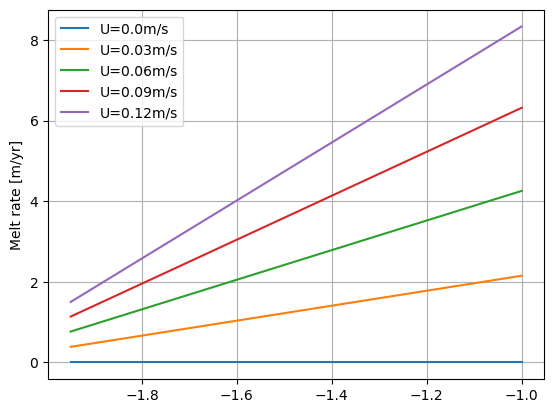

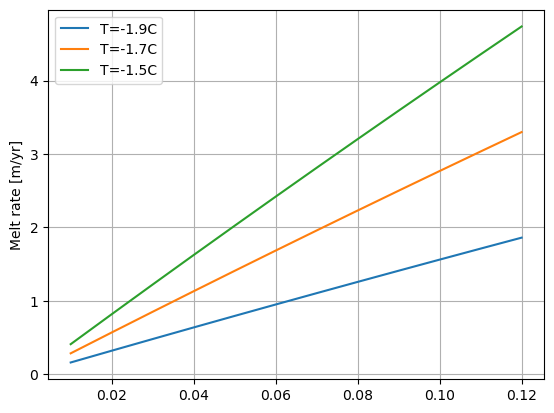

In [81]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import sympy # equation solver
from scipy.optimize import minimize # minimizing
import h5py # lese matlab data
# h5py-3.11.0
%matplotlib inline
#
# quantile-quantile plot
# import statsmodels.api as sm
#sm.qqplot_2samples(x, y, line='45')
#plt.title('Q-Q plot of x and y')
#plt.xlabel('Quantiles of x')
#plt.ylabel('Quantiles of y')
#plt.grid(True)
#plt.show()

# Constants, from Jenkins
rho_i=916
L_i=334000
rho_ic_i_k_i=2.1
rho_w=1030
c_w=3974
c_i=2108 # from internet, not in Jenkins tables

gamma_1=-0.0573
gamma_2=0.0832
gamma_3=-7.53*10**-4

# Elins' values
# CdTt=0.0011 # Thermal Stanton
# CdTs=3.1*10**-5 # Diffusion Stanton number
# CdTts=5.9*10**-4 # Stanton number - not used?

#CdTt=0.02*0.0011 # Thermal Stanton
#CdTs=0.15*3.1*10**-5 # Diffusion Stanton number

# best fit so far
# CdTt=0.15*0.0011 # Thermal Stanton
# CdTs=0.2*3.1*10**-5 # Diffusion Stanton number
# r2 = 0.65 for Pb O 400

CdTt=0.15*0.0011 # Thermal Stanton
CdTs=0.3*3.1*10**-5 # Diffusion Stanton number

CdTts=5.9*10**-4 # Stanton number - not used?
Cd=0.0097 # not used
Tt=0.011 # not used
Ts=3.1*10**-4 # not used
Tts=0.006 #  not used

# Fixed values
T_i=-20
S_w=34.4
Pb=360


# Constants, Elin
A=rho_i*L_i
B=rho_i*c_i*T_i #
C=rho_i*c_i  # 
D=rho_w*c_w*CdTt
E=rho_w*CdTs
F=gamma_2+gamma_3*Pb

# a is melt/second! multiply by numbers of seconds per year to get m/yr
N=365*24*3600

fig,ax=plt.subplots()

for U in np.linspace(0,0.12,5):
    TT=np.linspace(-1.95,-1,25)
    aa=[]
    for i,T in enumerate(TT):
        a = sympy.Symbol('a')
        f1=(B-A)*a-C*a*(gamma_1*S_w*E/(E+rho_i*a)+F)-D*U*(gamma_1*S_w*E/(E+rho_i*a)+F)+D*U*T
        aa.append(N*sympy.nsolve(f1,a,1/N))
    ax.plot(TT,aa,label='U='+str(U)+'m/s')
ax.legend()
ax.grid()   
ax.set_ylabel('Melt rate [m/yr]')


fig,ax=plt.subplots()
for T in [-1.9,-1.7,-1.5]:
    UU=np.linspace(0.01,0.12,12)
    aa=[]
    for i,U in enumerate(UU):
        a = sympy.Symbol('a')
        f1=(B-A)*a-C*a*(gamma_1*S_w*E/(E+rho_i*a)+F)-D*U*(gamma_1*S_w*E/(E+rho_i*a)+F)+D*U*T
        aa.append(N*sympy.nsolve(f1,a,1/N))
    ax.plot(UU,aa,label='T='+str(T)+'C')
ax.legend()
ax.grid()   
ax.set_ylabel('Melt rate [m/yr]')


In [2]:

U=0.1
T=-1.9
a = sympy.Symbol('a')
f1=(B-A)*a-C*a*(gamma_1*S_w*E/(E+rho_i*a)+F)-D*U*(gamma_1*S_w*E/(E+rho_i*a)+F)+D*U*T
a = sympy.nsolve(f1,a,1/N)

S_b=S_w*E/(E+rho_i*a)
T_b=gamma_1*S_b+F

check=-A*a+B*a-C*T_b*a-D*U*(T_b-T)
print(check) # Should be very close to zero
print('S_b='+str(S_b))
print('T_b='+str(T_b))
print('Meltrate='+str(a*N))

-1.77635683940025e-14
S_b=34.1614965748609
T_b=-2.14533375373953
Meltrate=1.53496253369346


In [3]:
aa=rho_i*(B-A-C*F)
bb=E*(B-A)-C*gamma_1*S_w*E-C*F*E-D*U*F*rho_i+D*U*T*rho_i
cc=D*U*T*E-D*U*F*E-D*U*gamma_1*S_w*E

a=(-bb-np.sqrt(bb**2-4*aa*cc))/(2*aa) # meltrate [m/s]
print(str(a*N))

1.5349625336934678


Try to implement minimization of RMS of observed melt and parameterized  melt based from 3-eqn solver following this recepie: https://datascience.stackexchange.com/questions/69092/how-to-minimize-mean-square-error-using-python

<KeysViewHDF5 ['dh', 'dh_lin', 'melt_lin', 'num', 'spd2', 'spd_lin', 'spdf2', 'spdr2', 't2', 't_lin', 'tr2', 'vsr', 'vsr_lin']>


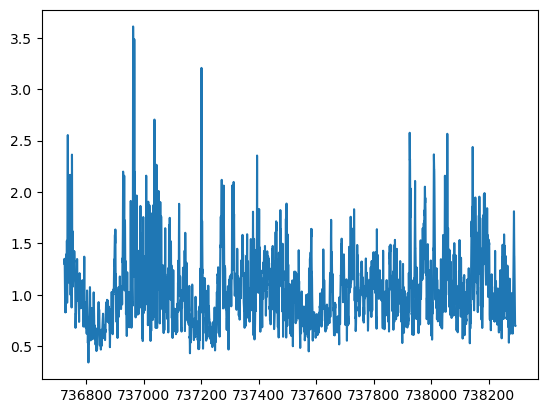

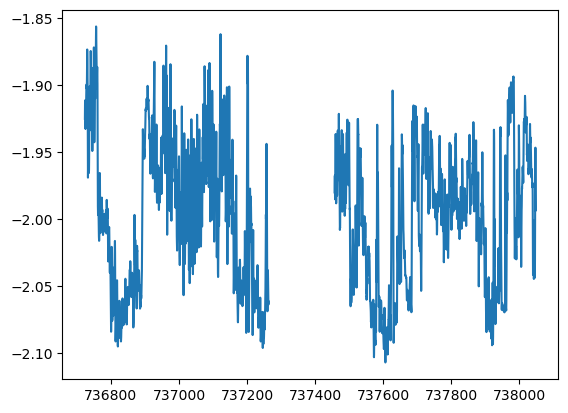

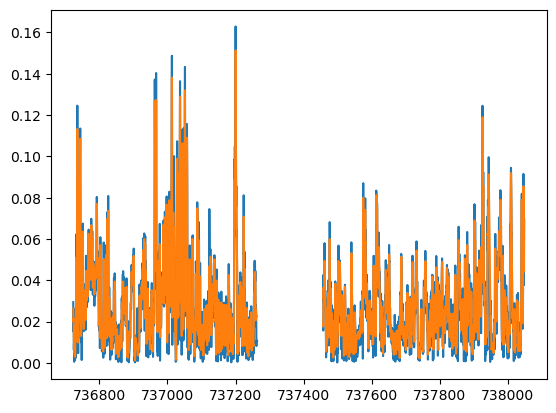

In [121]:
# read obs data
f = h5py.File('M2_series.mat','r')
print(f.keys())

num = np.array(f.get('num'))
dh = np.array(f.get('dh'))
vsr = np.array(f.get('vsr'))
vsr_lin = np.array(f.get('vsr_lin'))
t2 = np.array(f.get('t2'))
spd2 = np.array(f.get('spd2'))

# tr2 = np.array(f.get('t2'))
spdf2 = np.array(f.get('spdf2'))

mm = -(dh-np.mean(vsr,axis=0))
# mm = -(dh-vsr_lin)
t = t2.T
spd = spd2.T
spd_ = spdf2.T

fig,ax=plt.subplots()
ax.plot(num, mm)
fig,ax=plt.subplots()
ax.plot(num, t)
fig,ax=plt.subplots()
ax.plot(num, spd)
ax.plot(num, spd_)



In [122]:
# find non-neagtive values
ii = np.isfinite(spd * t * mm)

UU = spd[ii] # + 0.07 fits magntude, but worsens r2
TT = t[ii] # + 0.15
mm_obs = mm[ii]

#rnd = np.random.rand(100)
#rndi = np.round(rnd*len(UU))

#UU = UU[rndi.astype('int64')]
#TT = TT[rndi.astype('int64')]
#mm_obs = mm_obs[rndi.astype('int64')]

#print(str(mm_obs))

In [123]:
# velocity and temperature series
#UU = np.linspace(0,0.12,25)
#TT = np.linspace(-1.95,-1,25)
## melt rate series
#melt_obs = UU*TT

# find non-neagtive values
# ii = np.isfinite(spd * t * mm)
# UU = spd[ii] # + 0.07 fits magntude, but worsens r2
# TT = t[ii] # + 0.15
# mm_obs = mm[ii]

def melt_para(ftt,fts,toff,uoff):
    aa=[]
    # CdTt=0.15*0.0011 # Thermal Stanton
    # CdTs=0.2*3.1*10**-5 # Diffusion Stanton number
    CdTt=ftt*0.0011 # Thermal Stanton
    CdTs=fts*3.1*10**-5 # Diffusion Stanton number

    # Constants, Elin
    A=rho_i*L_i
    B=rho_i*c_i*T_i #
    C=rho_i*c_i  # 
    D=rho_w*c_w*CdTt
    E=rho_w*CdTs
    F=gamma_2+gamma_3*Pb

    T = TT + toff
    U = UU + uoff
    aa=rho_i*(B-A-C*F)
    bb=E*(B-A)-C*gamma_1*S_w*E-C*F*E-D*U*F*rho_i+D*U*T*rho_i
    cc=D*U*T*E-D*U*F*E-D*U*gamma_1*S_w*E

    aa=N*(-bb-np.sqrt(bb**2-4*aa*cc))/(2*aa) # meltrate [m/yr]
    
    #for i,element in enumerate(TT):
    #    T = TT[i] + toff
    #    U = UU[i] + uoff
    #    #a = 5 +5
    #    # a = T_i +5
    #    a = sympy.Symbol('a')
    #    f1=(B-A)*a-C*a*(gamma_1*S_w*E/(E+rho_i*a)+F)-D*U*(gamma_1*S_w*E/(E+rho_i*a)+F)+D*U*T
    #    aa.append(N*sympy.nsolve(f1,a,1/N))
    return aa


# from sklearn.metrics import r2_score

def r2_score_man(y_obs, y_pred):
    """
    Calculate the coefficient of determination (R^2) between the observed data and the predicted data.

    Parameters:
    y_obs (numpy array): The observed data.
    y_pred (numpy array): The predicted data.

    Returns:
    float: The R^2 value.
    """
    # Calculate the residuals (differences between observed and predicted data)
    resid = y_pred - y_obs
    
    # Calculate the sum of squares of residuals
    SSresid = np.sum(resid ** 2)
    
    # Calculate the total sum of squares (variance of the observed data times the number of observations minus one)
    # Note: np.var with ddof=1 calculates the sample variance
    SStotal = (len(y_obs) - 1) * np.var(y_obs, ddof=1)
    
    # Calculate the R^2 value
    r2_val = 1 - SSresid / SStotal
    
    return r2_val

# Example usage
# ys = np.array([...])  # Observed data
# y1s = np.array([...]) # Predicted data
# r_squared = calculate_r_squared(ys, y1s)
# print(r_squared)

# mm_par = melt_para(ftt,fts,toff,soff)
# mm_par = melt_para(0.15,0.2,0,0)

# first extension with so far best fit
#ftt = np.arange(0.01, 0.1, 0.005) # np.array([0.01, 0.05, 0.15, 0.2, 0.5, 1, 1.5])
#fts = np.array([0.005, 0.007, 0.01, 0.013, 0.015, 0.4, 0.5, 0.6]) # np.arange(0.01, 1.2, 0.01) # np.array([0.01, 0.05, 0.15, 0.2, 0.5, 1, 1.5])
#toffs = np.arange(-0.15, 0.15, 0.01) 
#uoffs = np.arange(-0.02, 0.08, 0.01) # np.arange(-0.1, 0.1, 0.01) 



ftt = np.arange(0.01, 0.1, 0.005) # np.array([0.01, 0.05, 0.15, 0.2, 0.5, 1, 1.5])
fts = np.array([0.005, 0.007, 0.01, 0.013, 0.015, 0.4, 0.5, 0.6, 1.5]) # np.arange(0.01, 1.2, 0.01) # np.array([0.01, 0.05, 0.15, 0.2, 0.5, 1, 1.5])
toffs = np.arange(-0.15, 0.15, 0.01) 
uoffs = np.arange(-0.02, 0.08, 0.01) # np.arange(-0.1, 0.1, 0.01) 

# large fts values
#ftt = np.arange(0.01, 0.2, 0.005) # np.array([0.01, 0.05, 0.15, 0.2, 0.5, 1, 1.5])
#fts = np.array([0.01, 0.1, 1, 1.5, 10, 10^5, 10**6, 5*10**7, 10**8, 5*10**8, 10**10, 10**15]) # np.arange(0.01, 1.2, 0.01) # np.array([0.01, 0.05, 0.15, 0.2, 0.5, 1, 1.5])
#toffs = np.arange(-0.16, 0.16, 0.02) 
#offs = np.arange(-0.02, 0.08, 0.01) # np.arange(-0.1, 0.1, 0.01) 

# original small set with good fit for offset, explore large fts gives best fit with square of filtered velocities
ftt = np.arange(0.05, 0.15, 0.01)
fts = np.array([0.2, 0.25, 0.3, 0.35, 1, 10**9, 5*10**9, 10**10, 5*10**10, 10**11])
toffs = np.arange(-0.05, 0.15, 0.01) 
uoffs = np.arange(-0.05, 0.1, 0.01) 


# original small set with good fit for offset
#ftt = np.array([0.01, 0.05, 0.15, 0.2, 0.5, 1, 1.5])
#fts = np.array([0.01, 0.05, 0.15, 0.2, 0.5, 1, 1.5])
#toffs = np.arange(-0.15, 0.15, 0.01) 
#uoffs = np.arange(-0.1, 0.1, 0.01) 

print('initialize arrays')

mm_pars = np.zeros((len(ftt), len(fts), len(toffs), len(uoffs), len(ii)))*np.nan
mm_r2s_off = np.zeros((len(ftt), len(fts), len(toffs), len(uoffs)))
mm_r2s_abs = np.zeros((len(ftt), len(fts), len(toffs), len(uoffs)))

print('start loop')

for i in range(ftt.size):
    #print(str(i))
    for j in range(fts.size):
        for k in range(toffs.size):
            for l in range(uoffs.size):
                try:
                    dum = np.array(melt_para(ftt[i],fts[j],toffs[k],uoffs[l]))
                except:
                    continiue
                mm_pars[i, j, k, l, np.squeeze(ii)] = dum
                mm_r2s_off[i, j, k, l] = r2_score_man(mm_obs-np.mean(mm_obs), dum-np.mean(dum))
                mm_r2s_abs[i, j, k, l] = r2_score_man(mm_obs, dum)
    sys.stdout.write('.')
    #print(str(j))
    #print(str(k))
    #print(str(l))
print('done')


initialize arrays
start loop
..........done


In [128]:
ims = np.where(mm_r2s_off>0.68)
ims = np.where(mm_r2s_off[:,:,:,2]>0.6)
np.nanmax(mm_r2s_off[:,:,:,10])
#uoffs[5]
toffs[5]

6.938893903907228e-18

In [131]:
#mm_r2s
im_off = np.where(mm_r2s_off==np.nanmax(mm_r2s_off[:,:,5,5])) # force toff=0, uoff=0, allow free abs offset
# im_off = np.where(mm_r2s_off==np.nanmax(mm_r2s_off)) # allow free uoff
im_abs = np.where(mm_r2s_abs==np.nanmax(mm_r2s_abs)) # allow free T & U
# im_abs = np.where(mm_r2s_off==np.nanmax(mm_r2s_off[:,:,5,:])) # force toff=0

print(str(np.nanmax(mm_r2s_off)))
print(im_off)
print(str(np.nanmax(mm_r2s_abs)))
print(im_abs)


print('')
print(ftt[im_off[0]])
print(ftt[im_abs[0]])
print('')
print(fts[im_off[1]])
print(fts[im_abs[1]])
print('')
print(toffs[im_off[2]])
print(toffs[im_abs[2]])
print('')
print(uoffs[im_off[3]])
print(uoffs[im_abs[3]])

0.710029292117934
(array([9], dtype=int64), array([6], dtype=int64), array([5], dtype=int64), array([5], dtype=int64))
0.7027088773581942
(array([4], dtype=int64), array([3], dtype=int64), array([17], dtype=int64), array([12], dtype=int64))

[0.14]
[0.09]

[5.e+09]
[0.35]

[6.9388939e-18]
[0.12]

[6.9388939e-18]
[0.07]


Original small set

0.7078869054704754
(array([2], dtype=int64), array([6], dtype=int64), array([15], dtype=int64), array([12], dtype=int64))
0.6791787375736618
(array([2], dtype=int64), array([1], dtype=int64), array([23], dtype=int64), array([15], dtype=int64))

[0.15]
[0.15]

[1.5]
[0.05]

[1.38777878e-16]
[0.08]

[0.02]
[0.05]


Extended set 1, note fts at max bound
0.7102115520524759
(array([25], dtype=int64), array([10], dtype=int64), array([9], dtype=int64), array([5], dtype=int64))
0.7028045489463073
(array([15], dtype=int64), array([5], dtype=int64), array([15], dtype=int64), array([9], dtype=int64))

[0.135]
[0.085]

[1.6]
[0.4]

[0.02]
[0.14]

[0.03]
[0.07]

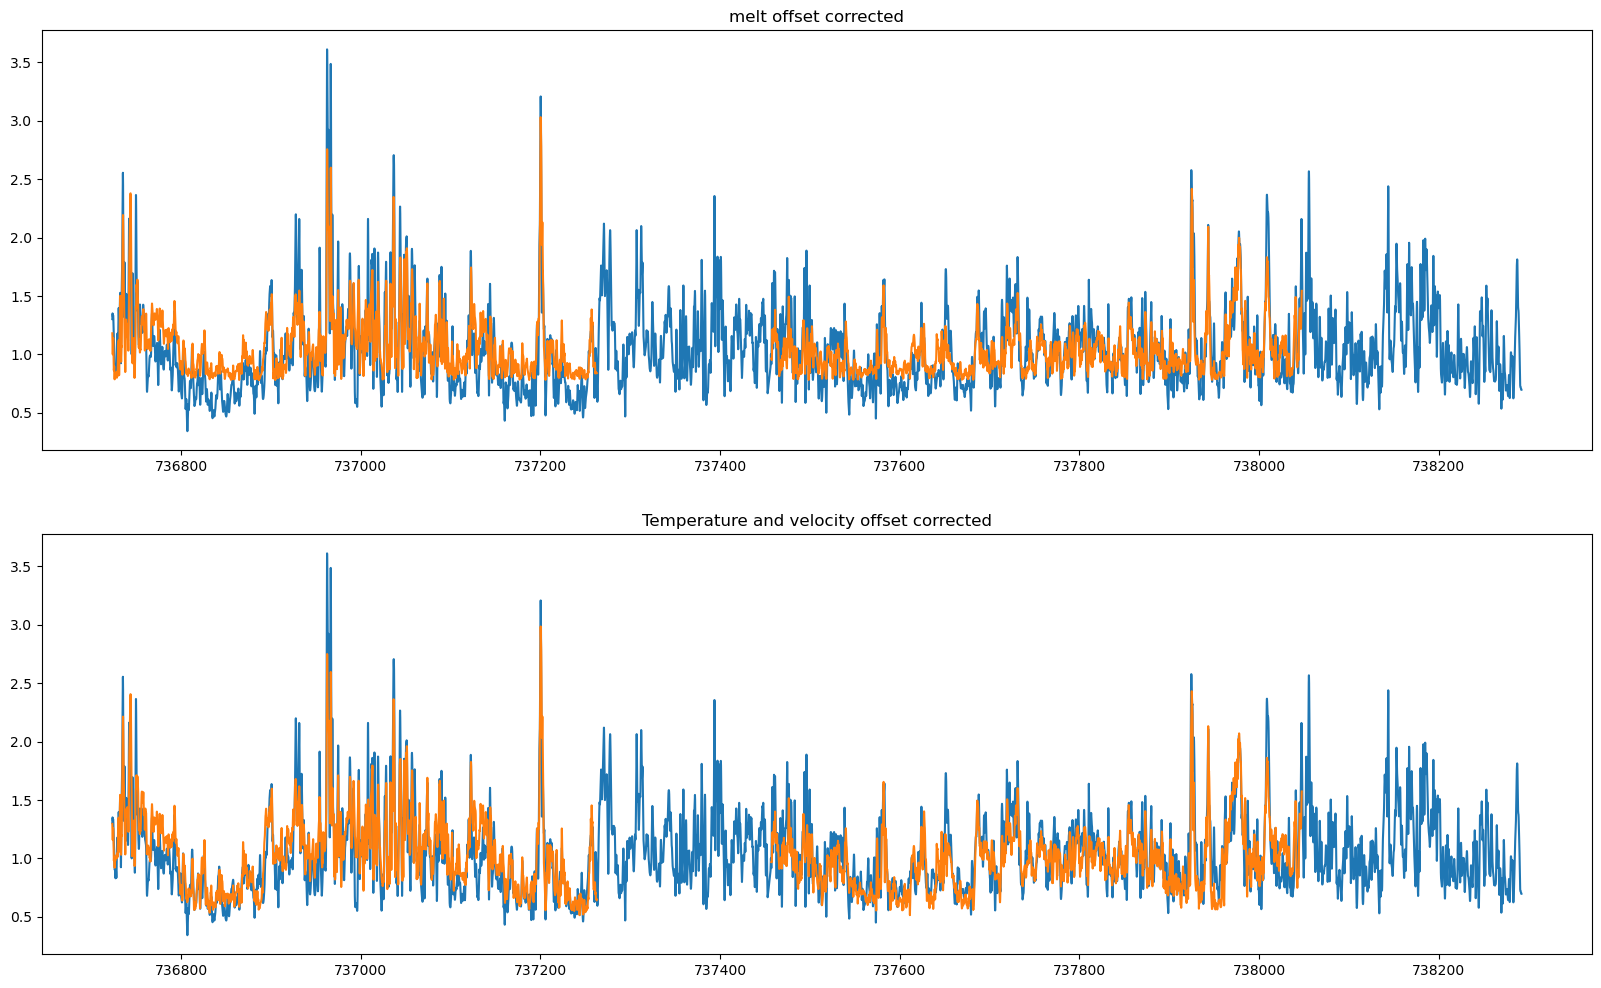

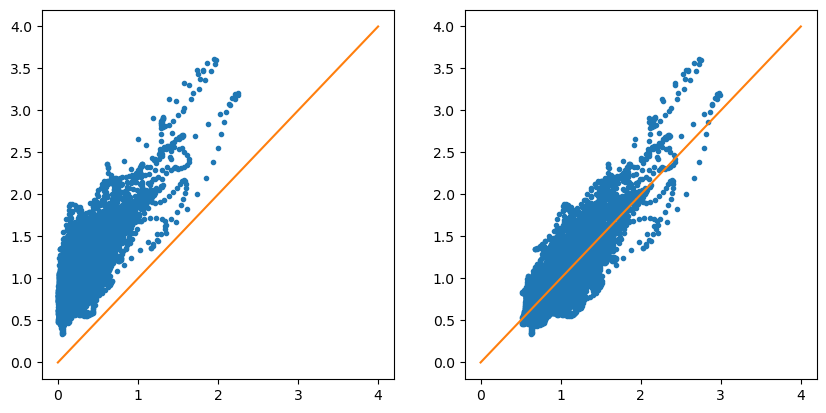

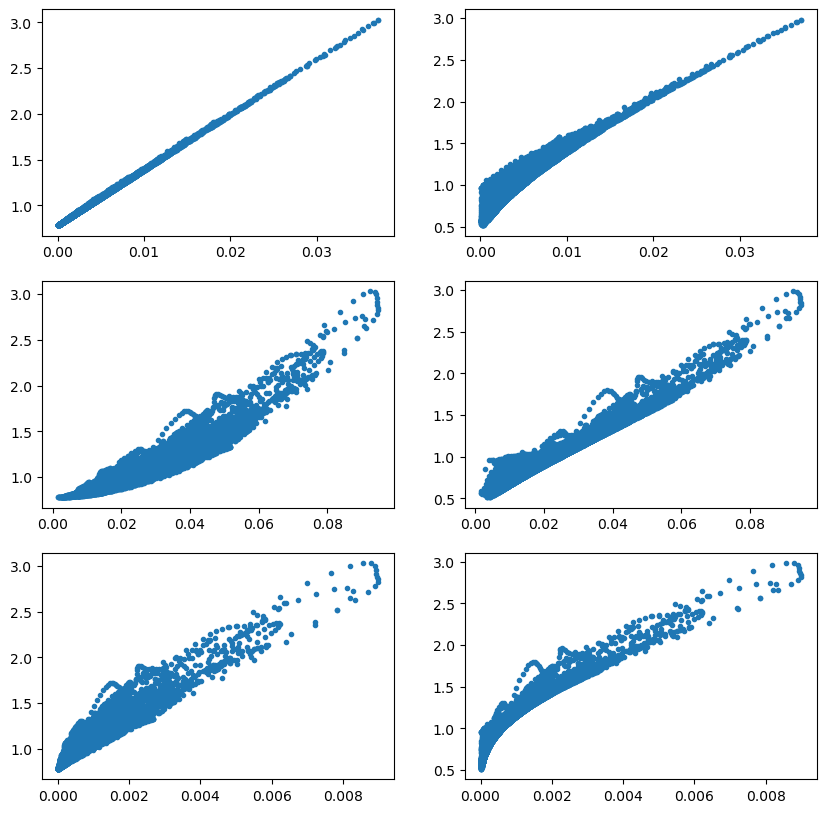

 
['GammaT *', '0.07']
['GammaS *', '5000000000.0']
['T offset ', '-0.019999999999999997']
['ustar offset ', '-0.04']
 


NameError: name 'moff' is not defined

In [132]:
# 2 1 6 3
#mmp=mm_pars[16,7,27,8,:]
# mmp=mm_pars[12,5,28,9,:]
mmp = mm_pars[im_off[0], im_off[1], im_off[2], im_off[3]]
mmp1 = mmp-(np.nanmean(mmp)-np.nanmean(mm))
# mmp1=mm_pars[2,1,5,7,:]
# mmp2=mm_pars[15,7,28,9,:]
mmp2 = mm_pars[im_abs[0], im_abs[1], im_abs[2], im_abs[3]]

fig,ax=plt.subplots(2)
# is more concise than this:
# fig = plt.figure()
# ax = fig.add_subplot(111)

# fig.figure(figsize=(10,6))
fig.set_figwidth(20)
fig.set_figheight(12)

ax[0].plot(num, mm)
ax[0].plot(np.squeeze(num), np.squeeze(mmp1))
#ax.plot(np.squeeze(num), np.mean(mmp[np.squeeze(ii)]))
ax[0].set_title('melt offset corrected')

ax[1].plot(num, mm)
ax[1].plot(np.squeeze(num), np.squeeze(mmp2))
ax[1].set_title('Temperature and velocity offset corrected')

plt.show()
#plt.savefig("mygraph.png")

#print(str(np.corrcoef(mm[ii],mmp[np.squeeze(ii)])))

#print(str(r2_score_man(mm[ii]-np.mean(mm[ii]),mmp[np.squeeze(ii)]-np.mean(mmp[np.squeeze(ii)]))))

#%matplotlib notebook
#%matplotlib inline
#%matplotlib qt

fig,ax=plt.subplots(1,2)
fig.set_figwidth(10)
ax[0].plot(mmp.T, mm,'.')
ax[0].plot([0, 4],[0, 4])

ax[1].plot(mmp2.T, mm,'.')
ax[1].plot([0, 4],[0, 4])

plt.show()


fig,ax=plt.subplots(3,2)
fig.set_figwidth(10)
fig.set_figheight(10)
ax[0,0].plot(spd*(2.15+t), mmp1.T,'.')
ax[0,1].plot(spd*(2.15+t), mmp2.T,'.')
ax[1,0].plot(np.sqrt(spd)*(2.15+t), mmp1.T,'.')
ax[1,1].plot(np.sqrt(spd)*(2.15+t), mmp2.T,'.')
ax[2,0].plot((spd)*(2.15+t)*(2.15+t), mmp1.T,'.')
ax[2,1].plot((spd)*(2.15+t)*(2.15+t), mmp2.T,'.')

plt.show()

print(' ')
print(['GammaT *', str(ftt[2])])
print(['GammaS *', str(fts[6])])
print(['T offset ', str(toffs[3])])
print(['ustar offset ', str(uoffs[1])])

#ftt = ftt = np.array([0.01, 0.05, 0.15, 0.2, 0.5, 1, 1.5])
#fts = fts = np.array([0.01, 0.05, 0.15, 0.2, 0.5, 1, 1.5])
#toffs = np.arange(-0.15, 0.15, 0.05) 
#uoffs = np.arange(0, 0.1, 0.02) 

print(' ')
#moff = np.mean(mm[ii])-np.mean(mmp[np.squeeze(ii)])
print(moff)


In [ ]:
dum = -spd*t

In [ ]:
np.shape(dum)

In [ ]:
fig,ax=plt.subplots(2,1)
fig.set_figwidth(10)
ax[0].plot(num,spd)
ax[1].plot(num,t)

Assessment of melt parameterizations.
The observed melt rates can be parameterized. Several fits with different parameters. 3 eqn, 2 eqn, emprirical relationship.
Varying strain would indicate a decreasing trend in melt rate that is not supported by the ocean observations. While the 3eqn. parameterization captures a large fraction of the variability, explanations for the offsets in u and t and the linear strain are less obvious. The 3 eqn fit suggests an offset in the observed velocities of 4 cm/s, which leads to an underestimate of the melt rates for low velocities. This may be related to buoyant plumes that are rising along the sloping ice base and dominate the velocity structure at the ice-ocean interface under low background flow conditions. If the linear trend in the strain is related the ice dynamics of the basal channel, this may also affect the slope and hence the plume velocity, providing an explanation for a trend in melt rates that woudl not be observed as changes in ocean properties 30-40 m below the ice base where our mooring is situated. The offset in temperature/ thermal driving is still hard to explain (needing a temperature inversion below the ice base), casting doubt on the absolute magnitude of the observed (parameterized) melting (and strain).

Stanton numbers for:
3eqn with melt offset, 3eqn with t&u offset, 2eqn same way; derive Cd range, gammat/gammas ratio; compare fit & distributions; project melt rates back with unceratainty